In [8]:
# For Google Colab / local machine
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive/')
    colab_path = "/content/drive/MyDrive/Masterarbeit/Code/two-hearts/"
    import sys
    sys.path.append(colab_path)
    !pip install neurokit2
else:
    print('Not running on CoLab')
    colab_path = ""

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
import pickle
from copy import deepcopy
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.signal as signal
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load lists / functions
from lists import dyads, num_dyads, participants, num_participants
from functions import cosine, rpeaks_cosine_interpolation

# Create list for indices with partners that did not
# take part in the experiment together
# with an equal gender distribution, e.g.:
# 0 1 2 3 4 5 6 7
# ->
# 0 3 4 7
sync_idx = sorted(
    [*participants[::4],
     *participants[3::4]])

In [10]:
# Make some noise
# discrete normal distribution

def make_noise(rpeaks_idx, noise_target):
    """Generates noise in amount of n = rpeaks_idx based on a discrete normal distribution with a sum of 0 \
        and a standard deviation of noise_target/100*mean(ibi) for each person.\n
        As there is no deterministic way to determine these values a while-loop is incoorperated. 
        The higher noise_target, the more time it takes.\n
        Returns a nested list with n numbers of noise and final percentage of noise based on the mean IBI value.\
        There are small deviations because of the rounded values.

    Args:
        rpeaks_idx (array): n & mean IBI
        noise_target (int): percentage of noise based on the mean IBI for each person. Used as the standard deviation of the normal distribution.

    Returns:
        [noise, noise_percentage] : nested list
    """
    num_rpeaks = len(rpeaks_idx)
    noise_size = num_rpeaks-2
    # num_rpeaks-2, 
    # because the first r-peak index does not represent an IBI
    # and the noise should end at the last original IBI
    
    # Get IBI
    ibi = [
        rpeaks_idx[s]-rpeaks_idx[s-1]
        for s in range(num_rpeaks)
        if s > 0
    ]
    
    ibi_mean = np.mean(np.array(ibi))
    noise_spread = int(round(noise_target/100*ibi_mean))

    noise = np.round(
        np.random.normal(
            scale=noise_spread, 
            size=noise_size))
    # Search for sum = 0
    while \
        sum(noise) != 0 or \
        np.round(np.std(noise), 1) != noise_spread:
        noise = np.round(
            np.random.normal(
                scale=noise_spread, 
                size=noise_size))
    # Convert to ints
    noise = [round(x) for x in noise]
    noise.insert(0, 0)
    noise.append(0)
    
    # Calculate average noise (%)

    noise_percentage = np.round(np.std(noise), 1)/ibi_mean*100
    noise_percentage = np.round(noise_percentage, 2)
    
    return [noise, noise_percentage]

# Preprocess data

In [11]:
sampling_rate = 2000
length = 5*60*sampling_rate

ecg_raw = {}
ecg = {}
rpeaks = {}
rpeaks_idx = {}
noise = []
con = "gaze"

In [12]:
# Prepeare original sample date based on con (SIT or GAZE)

# Load data: raw ecgs for 300 s at 2000 Hz
ecg_raw[con] = np.load(f"{colab_path}data/ecg_raw/ecg_raw_{con}.npy")

# Clean and normalize data
ecg[con] = [
    nk.ecg_clean(
        ecg_raw[con][i], 
        sampling_rate=sampling_rate, 
        method="neurokit")
    for i in participants
]
# Get R-peaks as a binary time series
rpeaks[con] = [
    nk.ecg_peaks(
        ecg[con][i], 
        sampling_rate=sampling_rate
        )[0]["ECG_R_Peaks"]
    for i in participants
]
rpeaks_idx[con] = [
    [
        s for s, 
        x in enumerate(rpeaks[con][i]) 
        if x == 1
    ]
    for i in participants
]

In [13]:
# Create SYNC with lag and different levels of noise based on sample data

noise_target = [0,2.5,5,7.5,10,12.5,15]
noise_added = {}
noise = {}
    
# Load noise data
with open(f'{colab_path}data/sync_noise.pickle', 'rb') as handle:
    noise = pickle.load(handle)

for x in noise_target:
    # Check if fitting noise data exists, else generate new noise
    if not list(noise.keys()) == noise_target and len(noise[0]) == num_participants:
        noise[x] = [
            # returns 2 vaules in a nested list: noise vaules @ [0] & noise percentage @ [1]
            make_noise(rpeaks_idx[con][i],noise_target=x)
            for i in participants
        ]
        # save new dictionary as pickle file
        with open(f'{colab_path}data/sync_noise.pickle', 'wb') as handle:
            pickle.dump(noise, handle, protocol=pickle.HIGHEST_PROTOCOL)

    rpeaks_idx["sync_temp"] = [
        np.array(rpeaks_idx["gaze"][i])+(noise[x][i][0])
        for i in participants
    ]

    rpeaks_idx[f"sync_{x}"] = [None]*(len(participants))
    rpeaks_idx[f"sync_{x}"][::2] = [
        rpeaks_idx["gaze"][idx]
        for idx in sync_idx
    ]
    rpeaks_idx[f"sync_{x}"][1::2] = [
        rpeaks_idx["sync_temp"][idx]
        for idx in sync_idx
    ]

    del rpeaks_idx["sync_temp"]

    # Add lag
    lag = 1*sampling_rate # 1 sec
    rpeaks_idx[f"sync_{x}"][1::2] = [
        rpeaks_idx[f"sync_{x}"][i]+np.array(lag)
        for i in participants
        if i % 2 == 1
    ]
    
    # Show noise
    noise_added[x] = [
        noise[x][idx][1]
        for idx in sync_idx
    ]

    print(f"### Targeted noise percentage: {x} % ###")
    print(
        f"Noise added:{noise_added[x]} %\
        \nTrue noise (mean): {np.mean(noise_added[x]):.2f} %\n")

### Targeted noise percentage: 0 % ###
Noise added:[0.0, 0.0, 0.0, 0.0] %        
True noise (mean): 0.00 %

### Targeted noise percentage: 2.5 % ###
Noise added:[2.48, 2.5, 2.51, 2.47] %        
True noise (mean): 2.49 %

### Targeted noise percentage: 5 % ###
Noise added:[5.01, 5.0, 5.02, 4.96] %        
True noise (mean): 5.00 %

### Targeted noise percentage: 7.5 % ###
Noise added:[7.48, 7.51, 7.46, 7.49] %        
True noise (mean): 7.48 %

### Targeted noise percentage: 10 % ###
Noise added:[9.96, 9.95, 9.98, 9.98] %        
True noise (mean): 9.97 %

### Targeted noise percentage: 12.5 % ###
Noise added:[12.44, 12.45, 12.49, 12.46] %        
True noise (mean): 12.46 %

### Targeted noise percentage: 15 % ###
Noise added:[14.97, 14.96, 15.0, 14.94] %        
True noise (mean): 14.97 %



In [14]:
conditions = [f"sync_{x}" for x in noise_target]
length = len(rpeaks["gaze"][0])

data_simul_temp = {}
for con in conditions:
    data_simul_temp[con] = [
        rpeaks_cosine_interpolation(
            rpeaks_idx[con][i],
            length+lag)  # add lag to length of time series
        for i in participants
    ]

    # Cut length of time series back to 600.000
    for j in [0, 1]:
        data_simul_temp[con][j::2] = [
            data_simul_temp[con][i][:-lag]
            for i in participants
            if i % 2 == j
        ]

In [15]:
# Trimming & downsampling to 50 Hz
sampling_rate_new = 50
data_trim = {}
data_down = {}

for con in conditions:
    # Trim data_mix to get rid of nans
    data_trim[con] = [
        # remove first and last 6 s (extra long because of lag)
        data_simul_temp[con][i][6*sampling_rate:-6*sampling_rate]
        for i in participants
    ]
    data_down[con] = [
        data_trim[con][i][::40]
        for i in participants
    ]

data = deepcopy(data_down)
for con in conditions:
    np.save(f"{colab_path}data/data_{con}.npy", data[con])


[ True  True  True ...  True  True  True]


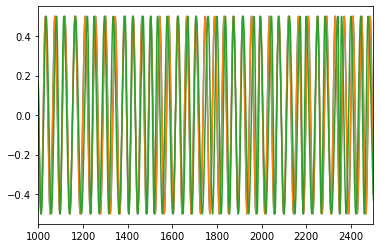

In [16]:
# Sanity check
# Should be all equal and true if noise_spread = 0
lag_new = 1*sampling_rate_new
plt.xlim(1000,2500)
plt.plot(data["sync_0"][0])
plt.plot(data["sync_0"][1][lag_new:])
plt.plot(data[f"sync_{noise_target[-1]}"][1][lag_new:])

print(np.equal(data["sync_0"][0][:-lag_new],data["sync_0"][1][lag_new:]))

### Deep Learning

In [17]:
# Import libraries
from lists import dyads, num_dyads, participants, num_participants

import os
import datetime
import random
import pickle
import IPython
import IPython.display
import numpy as np
from numpy import array, hstack
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector,\
    TimeDistributed, Input, BatchNormalization, multiply,\
    concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

print("TensorFlow version:", tensorflow.version.VERSION)

TensorFlow version: 2.8.2


In [18]:
# Function for controlling random number generator
def seed_value(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)

## Deep Learning

In [19]:
# Set sampling rate
sampling_rate = 50
print("Sampling rate:", sampling_rate)

# Set number of time steps
n_steps_in, n_steps_out = 5*sampling_rate, 2*sampling_rate
print("Time steps:", n_steps_in, n_steps_out)

# Set conditions
conditions
print("Conditions:", conditions)

# Show number of participants
print("Participants:", num_participants)

# Show number of dyads
print("Dyads:", num_dyads)

# # Set number of runs
# runs = ["01", "02", "03"]
# # runs = list(range(0,3))

# print("Number of training runs:", len(runs))

Sampling rate: 50
Time steps: 250 100
Conditions: ['sync_0', 'sync_2.5', 'sync_5', 'sync_7.5', 'sync_10', 'sync_12.5', 'sync_15']
Participants: 8
Dyads: 4


In [20]:
# Prepare sample data
def sample_preperation(condition):

    # Load data
    data = np.load(f"{colab_path}data/data_{condition}.npy")
    print(f"Loaded data with shape {data.shape} and type {data.dtype}")

    # Create empty samples
    X_input_train = np.empty(
        (0, n_steps_in, 2))
    X_input_vali = np.empty(
        (0, n_steps_in, 2))
    X_input_test = np.empty(
        (0, n_steps_in, 2))
    y_output_train = np.empty(
        (0, n_steps_out, 2))
    y_output_vali = np.empty(
        (0, n_steps_out, 2))
    y_output_test = np.empty(
        (0, n_steps_out, 2))

    # Split a multivariate sequence into samples (modified from Brownlee 2018, p.156)
    def split_sequences(
            sequences,
            n_steps_in,
            n_steps_out):
        X, y = list(), list()
        for i in range(len(sequences)):
            if i % (sampling_rate) == 0:  # to reduce redundancy in samples
                # find the end of this pattern
                end_ix = i + n_steps_in
                out_end_ix = end_ix + n_steps_out
                # check if we are beyond the dataset
                if out_end_ix > len(sequences):
                    break
                # gather input and output parts of the pattern
                seq_x, seq_y = sequences[i:end_ix,:], sequences[end_ix:out_end_ix, :]
                X.append(seq_x)
                y.append(seq_y)
        return array(X), array(y)

    # index for dyads
    for x in participants[::2]:
        # define input sequence
        in_seq1 = data[x]
        in_seq2 = data[x+1]
        # convert to [rows, columns] structure
        in_seq1 = in_seq1.reshape((len(in_seq1), 1))
        in_seq2 = in_seq2.reshape((len(in_seq2), 1))
        # horizontally stack columns
        dataset = hstack((in_seq1, in_seq2))
        # covert into input/output
        X, y = split_sequences(
            dataset,
            n_steps_in,
            n_steps_out)
        # data split
        num_train_samples = int(0.6 * len(X))
        num_val_samples = int(0.2 * len(X))
        num_test_samples = len(X) - num_train_samples - num_val_samples
        # append data for multiple dyads
        X_input_train = np.append(
            X_input_train, 
            X[:num_train_samples], 
            axis=0)
        y_output_train = np.append(
            y_output_train, 
            y[:num_train_samples], 
            axis=0)
        X_input_vali = np.append(
            X_input_vali, 
            X[num_train_samples:(num_train_samples+num_val_samples)],
            axis=0)
        y_output_vali = np.append(
            y_output_vali, 
            y[num_train_samples:(num_train_samples+num_val_samples)],
            axis=0)
        X_input_test = np.append(
            X_input_test,
            X[(num_train_samples+num_val_samples):], 
            axis=0)
        y_output_test = np.append(
            y_output_test, 
            y[(num_train_samples+num_val_samples):], 
            axis=0)

    # Create dictionary
    samples = {
        "X_input_train": X_input_train,
        "y_output_train": y_output_train,
        "X_input_vali": X_input_vali,
        "y_output_vali": y_output_vali,
        "X_input_test": X_input_test,
        "y_output_test": y_output_test
    }

    print("Length of samples for each set:", len(
        X_input_train), len(X_input_vali), len(X_input_test))

    return samples


In [21]:
# Define simple seq2seq model
# Modified from Wieniawska 2020
# (https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb)

def lstm_decoder_encoder(samples, units=100):
    # Input layer
    input_train = Input(
        shape=(
            samples["X_input_train"].shape[1],
            samples["X_input_train"].shape[2]))
    output_train = Input(
        shape=(
            samples["y_output_train"].shape[1],
            samples["y_output_train"].shape[2]))

    # Encoder LSTM with last state_h and state_c
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
        units,
        activation='elu',
        recurrent_dropout=0.1,
        return_sequences=False,
        return_state=True)(
            input_train)

    # Batch normalisation to avoid gradient explosion
    # center=False as mean is always 0
    encoder_last_h1 = BatchNormalization(
        momentum=0.6,
        center=False)(
            encoder_last_h1)
    encoder_last_c = BatchNormalization(
        momentum=0.6,
        center=False)(
            encoder_last_c)

    # Decoder LSTM
    decoder = RepeatVector(output_train.shape[1])(
        encoder_last_h1)
    decoder = LSTM(
        units,
        activation='elu',
        return_state=False,
        return_sequences=True)(
            decoder,
            initial_state=[
                encoder_last_h1,
                encoder_last_c])

    # Dense layer with repeated weights
    out = TimeDistributed(Dense(output_train.shape[2]))(
        decoder)

    # Compile model
    model = Model(
        inputs=input_train,
        outputs=out)
    opt = Adam(
        learning_rate=0.001,
        clipnorm=1)
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=['mae'])

    return model


In [22]:
# Fit model
def fit_model(model, samples):
    epc = 500
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min',
        patience=50, 
        restore_best_weights=True)
    history = model.fit(
        samples["X_input_train"], 
        samples["y_output_train"],  
        validation_data=(
            samples["X_input_vali"], 
            samples["y_output_vali"]),
        epochs=epc, 
        verbose=1,
        callbacks=[es],
        batch_size=64, 
        shuffle=True)

    return model, history

In [ ]:
# Execute over all conditions for n trials
samples_all = {}
model_all = {}
history_all = {}
results_all = {}
predictions_all = {}
data_all = {}


seed_value(0) # control random number generator ##1!!!
# iterate over conditions
for i,con in enumerate(conditions):
    print(f"Condition: {con}")
    samples = sample_preperation(con)
    samples_all[con] = samples
    model = lstm_decoder_encoder(samples)
    model, history = fit_model(model, samples)
    model_path = f"model/model_{con}.h5"
    # extra path because models aren't pickable in tensorflow < 2.7 and can't be imported via pickle
    model_all[con] = model_path
    model.save(model_path)  # -> using model.save() instead
    history_all[con] = history.history
    results = model.evaluate(
        samples["X_input_test"], 
        samples["y_output_test"], 
        batch_size=64)
    results_all[con] = results
    predictions = model.predict(
        samples["X_input_test"], 
        batch_size=64)
    predictions_all[con] = predictions
# deepcopy to prevent reusing the same dictionary
samples_all_copy = deepcopy(samples_all)
model_all_copy = deepcopy(model_all)
history_all_copy = deepcopy(history_all)
results_all_copy = deepcopy(results_all)
predictions_all_copy = deepcopy(predictions_all)
# create nested dictionary for everything
data_all["samples_all"] = samples_all_copy
data_all["model_all"] = model_all_copy
data_all["history_all"] = history_all_copy
data_all["results_all"] = results_all_copy
data_all["predictions_all"] = predictions_all_copy

Condition: sync_0
Loaded data with shape (8, 14400) and type float64
Length of samples for each set: 676 224 228
Epoch 1/500
11/11 [==============================] - 13s 753ms/step - loss: 0.2001 - mae: 0.3613 - val_loss: 0.1255 - val_mae: 0.3159
Epoch 2/500
11/11 [==============================] - 8s 684ms/step - loss: 0.1254 - mae: 0.3115 - val_loss: 0.1210 - val_mae: 0.3050
Epoch 3/500
11/11 [==============================] - 7s 671ms/step - loss: 0.1181 - mae: 0.3023 - val_loss: 0.1147 - val_mae: 0.2977
Epoch 4/500
11/11 [==============================] - 8s 690ms/step - loss: 0.1141 - mae: 0.2967 - val_loss: 0.1121 - val_mae: 0.2930
Epoch 5/500
11/11 [==============================] - 8s 690ms/step - loss: 0.1113 - mae: 0.2916 - val_loss: 0.1093 - val_mae: 0.2882
Epoch 6/500
11/11 [==============================] - 8s 700ms/step - loss: 0.1084 - mae: 0.2863 - val_loss: 0.1063 - val_mae: 0.2823
Epoch 7/500
11/11 [==============================] - 8s 700ms/step - loss: 0.1053 - mae:

In [ ]:
for x in conditions: print(x,data_all["results_all"][x])

sync_0 [0.010887224227190018, 0.06497863680124283]
sync_2.5 [0.01218795869499445, 0.07143497467041016]
sync_5 [0.015165925957262516, 0.08406804502010345]
sync_7.5 [0.01889408379793167, 0.09530308842658997]
sync_10 [0.02483653649687767, 0.10998398065567017]
sync_12.5 [0.03246041387319565, 0.13143214583396912]
sync_15 [0.03192351758480072, 0.12555307149887085]
